In [2]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
from coffea.util import load
import numpy as np
import pandas as pd
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

from pprint import pprint 
hep.style.use(hep.style.ROOT)

import hist

In [3]:
!pwd

/work/dvalsecc/ttHbb/PocketCoffea/notebooks/JetTagging


In [4]:
file = "../../output/parton_matching_dR03_training_dataset_v05/output.coffea"
out = load(file)
out.keys()

dict_keys(['sum_genweights', 'sumw', 'cutflow', 'seed_chunk', 'variables', 'columns', 'processing_metadata', 'scale_genweight'])

Number of events == "entries in the dataset" in each category

In [5]:
out["cutflow"]

{'initial': {'ttHTobb': 9668000},
 'skim': {'ttHTobb': 2141301},
 'presel': {'ttHTobb': 1401488},
 '4j': {'ttHTobb': 1401488},
 '5j': {'ttHTobb': 1220393},
 '6j': {'ttHTobb': 886499},
 '7j': {'ttHTobb': 514291},
 '8j': {'ttHTobb': 245593}}

Number of predicted physics events (weighted) during the datataking period

In [6]:
out["sumw"] 

{'4j': {'ttHTobb': 2375.708207453472},
 '5j': {'ttHTobb': 2070.061912904978},
 '6j': {'ttHTobb': 1503.4472136726142},
 '7j': {'ttHTobb': 871.7508919105194},
 '8j': {'ttHTobb': 416.99957589928493}}

# Look at the variables
Histogram lib: https://github.com/scikit-hep/hist

In [23]:
out["variables"].keys()

dict_keys(['JetGood_eta', 'JetGood_pt', 'JetGood_phi', 'JetGood_btagDeepFlavB', 'BJetGood_eta', 'BJetGood_pt', 'BJetGood_phi', 'BJetGood_btagDeepFlavB', 'ElectronGood_eta', 'ElectronGood_pt', 'ElectronGood_phi', 'ElectronGood_etaSC', 'MuonGood_eta', 'MuonGood_pt', 'MuonGood_phi', 'nJets', 'nBJets', 'JetGood_eta_1', 'JetGood_pt_1', 'JetGood_phi_1', 'JetGood_btagDeepFlavB_1', 'JetGood_eta_2', 'JetGood_pt_2', 'JetGood_phi_2', 'JetGood_btagDeepFlavB_2', 'JetGood_eta_3', 'JetGood_pt_3', 'JetGood_phi_3', 'JetGood_btagDeepFlavB_3', 'JetGood_eta_4', 'JetGood_pt_4', 'JetGood_phi_4', 'JetGood_btagDeepFlavB_4', 'JetGood_eta_5', 'JetGood_pt_5', 'JetGood_phi_5', 'JetGood_btagDeepFlavB_5', 'bjet_eta_1', 'bjet_pt_1', 'bjet_phi_1', 'bjet_btagDeepFlavB_1', 'bjet_eta_2', 'bjet_pt_2', 'bjet_phi_2', 'bjet_btagDeepFlavB_2', 'bjet_eta_3', 'bjet_pt_3', 'bjet_phi_3', 'bjet_btagDeepFlavB_3', 'bjet_eta_4', 'bjet_pt_4', 'bjet_phi_4', 'bjet_btagDeepFlavB_4', 'bjet_eta_5', 'bjet_pt_5', 'bjet_phi_5', 'bjet_btagDeep

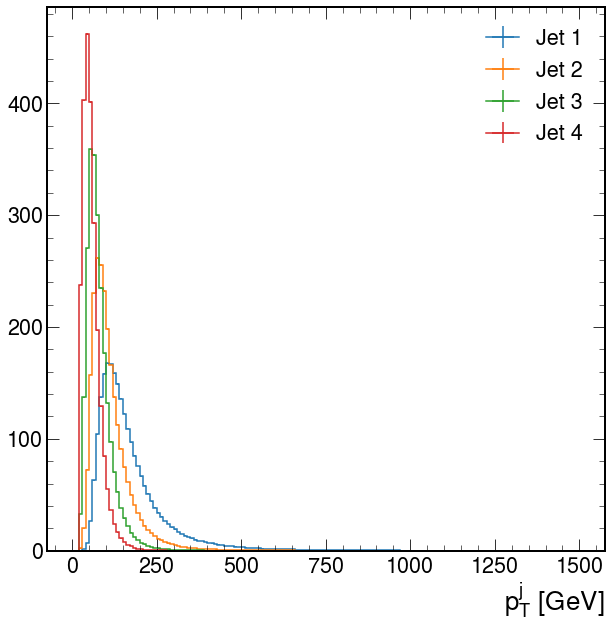

In [31]:
for i in range(1,5):
    h = out["variables"][f"JetGood_pt_{i}"]["ttHTobb"]
    hep.histplot(h[{"cat": "4j", "year":"2018","variation":"nominal"}], label=f"Jet {i}")
plt.legend()

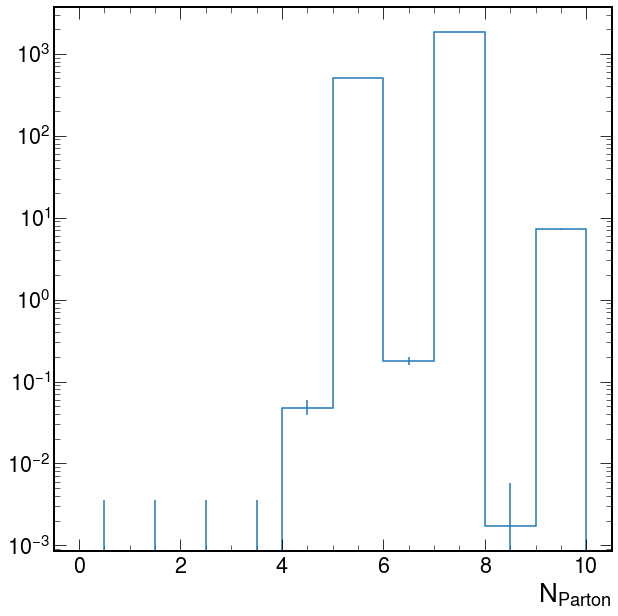

In [36]:
h = out["variables"][f"nPartons"]["ttHTobb"]
hep.histplot(h[{"cat": "4j", "year":"2018","variation":"nominal"}])
plt.yscale("log")

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fb14a1c00d0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

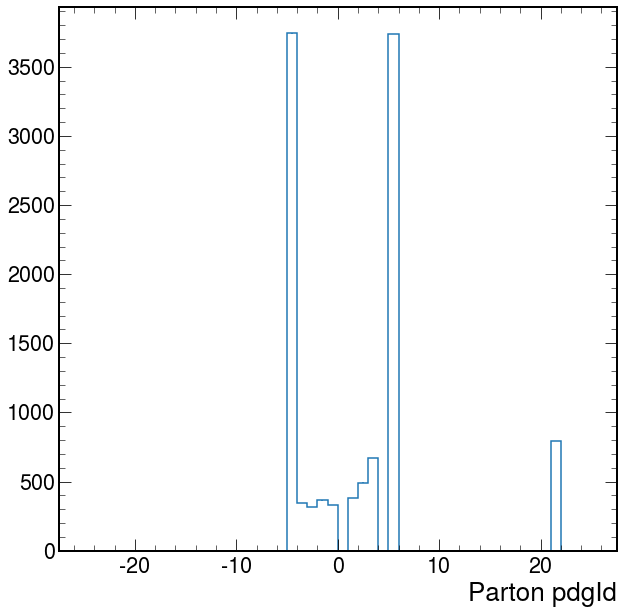

In [34]:
h = out["variables"][f"PartonMatched_pdgId"]["ttHTobb"]
hep.histplot(h[{"cat": "4j", "year":"2018","variation":"nominal"}])

# Look at the event by event dataset

In [7]:
cols = out["columns"]["4j"]

cols

{'npartons_tot': {'ttHTobb': column_accumulator(array([5, 7, 7, ..., 7, 7, 7]))},
 'parton_pt': {'ttHTobb': column_accumulator(array([99.13281 , 75.30078 , 77.42578 , ..., 42.259766, 31.625   ,
         98.75    ], dtype=float32))},
 'parton_eta': {'ttHTobb': column_accumulator(array([-0.3526001 , -1.718689  ,  1.0244751 , ...,  0.12541962,
         -0.10571289,  0.8378906 ], dtype=float32))},
 'parton_phi': {'ttHTobb': column_accumulator(array([ 1.7442627, -1.4053345,  1.0053711, ...,  1.4758301,  1.25     ,
         -1.8710938], dtype=float32))},
 'parton_pdgId': {'ttHTobb': column_accumulator(array([ 2,  5, -5, ..., -2,  5, -5], dtype=int32))},
 'parton_prov': {'ttHTobb': column_accumulator(array([2, 3, 1, ..., 2, 1, 1]))},
 'npartons_matched': {'ttHTobb': column_accumulator(array([4, 5, 6, ..., 4, 5, 5]))},
 'matched_parton_pt': {'ttHTobb': column_accumulator(array([99.1328125 , 75.30078125, 79.75      , ..., 98.75      ,
         37.50390625, 22.99902344]))},
 'matched_parton_eta'

### Recreate the awkward array

We have all the columns for partons, matched_partons and jets --> we can recollect them in a single Awkward array representing
partons, matched_partons and jets.  
We do so by `ak.zip` and then we can un-flatten the array, since we have also saved the number of object in each event. 
N.B.: Remember that the `matched_partons`  collections is ordered as the jet one. 

### Provenance
- 1 = jets from the higgs
- 2 = jets from the hadronically decaying top (1 b and 2 quarks)
- 3 = jet from the leptonically decaying top (1b)
- 4 = additiona radiation (gluon or quark)

In [8]:
partons = ak.unflatten(ak.zip({"pt": cols["parton_pt"]["ttHTobb"].value,
                              "eta": cols["parton_eta"]["ttHTobb"].value,
                              "phi": cols["parton_phi"]["ttHTobb"].value,
                              "pdgId": cols["parton_pdgId"]["ttHTobb"].value, 
                              "prov": cols["parton_prov"]["ttHTobb"].value},
                         with_name='PtEtaPhiMCandidate'),
                     cols["npartons_tot"]["ttHTobb"].value)

partons_matched= ak.unflatten(ak.zip({"pt": cols["matched_parton_pt"]["ttHTobb"].value,
                              "eta": cols["matched_parton_eta"]["ttHTobb"].value,
                              "phi": cols["matched_parton_phi"]["ttHTobb"].value,
                              "pdgId": cols["matched_parton_pdgId"]["ttHTobb"].value, 
                              "prov": cols["matched_parton_prov"]["ttHTobb"].value},
                         with_name='PtEtaPhiMCandidate'),
                     cols["matched_jet_pt_size"]["ttHTobb"].value)

jets = ak.unflatten(ak.zip({"pt": cols["jet_pt"]["ttHTobb"].value,
                              "eta": cols["jet_eta"]["ttHTobb"].value,
                              "phi": cols["jet_phi"]["ttHTobb"].value,
                              "btag": cols["jet_btag"]["ttHTobb"].value},
                         with_name='PtEtaPhiMCandidate'),
                     cols["jet_pt_size"]["ttHTobb"].value)

jets_matched = ak.unflatten(ak.zip({"pt": cols["matched_jet_pt"]["ttHTobb"].value,
                              "eta": cols["matched_jet_eta"]["ttHTobb"].value,
                              "phi": cols["matched_jet_phi"]["ttHTobb"].value,
                              "btag": cols["matched_jet_btag"]["ttHTobb"].value,
                            "prov": cols["matched_parton_prov"]["ttHTobb"].value},
                         with_name='PtEtaPhiMCandidate'),
                     cols["matched_jet_pt_size"]["ttHTobb"].value)

Masking again the missing matched partons replacing -999 with None for awkward utils

In [28]:
jets = ak.mask(jets, jets.pt==-999, None)
jets_matched = ak.mask(jets_matched, jets_matched.pt==-999, None)
partons_matched = ak.mask(partons_matched, partons_matched.pt==-999, None)

Also adding directly to the jet collection the information about if is it matched

In [30]:
is_jet_matched = ~ak.is_none(jets_matched, axis=1)
jets = ak.with_field(jets, is_jet_matched, "matched")
jets = ak.with_field(jets, jets_matched.prov, "prov")

In [101]:
partons[0:10].pdgId.tolist()

[[2, 5, -5, 5, -5],
 [2, 5, -5, 3, -4, 5, -5],
 [21, 5, -5, -1, 2, 5, -5],
 [21, 5, -5, 5, -5],
 [21, 5, -5, -3, 4, 5, -5],
 [21, 5, -5, 3, -4, 5, -5],
 [21, 5, -5, -3, 4, 5, -5],
 [21, 5, -5, -1, 2, 5, -5],
 [2, 5, -5, -1, 4, 5, -5],
 [-4, 5, -5, 3, -4, 5, -5]]

In [38]:
partons[0:10].prov.tolist()

[[2, 3, 1, 1, -1],
 [4, 3, 2, 2, 2, 1, 1],
 [4, 2, 3, 2, 2, 1, 1],
 [2, 3, 1, 1, -1],
 [4, 2, 3, 2, 2, 1, 1],
 [4, 3, 2, 2, 2, 1, 1],
 [4, 2, 3, 2, 2, 1, 1],
 [4, 2, 3, 2, 2, 1, 1],
 [4, 2, 3, 2, 2, 1, 1],
 [4, 3, 2, 2, 2, 1, 1]]

In [102]:
partons_matched[0:10].pdgId.tolist()

[[2, 5, -5, -5, None, None],
 [-5, 5, None, 2, -4, None, 5],
 [-1, 5, 2, -5, 5, -5],
 [21, -5, -5, 5, None, None],
 [-5, 5, -5, -3],
 [21, -5, -4, -5, None, None, 5],
 [5, 5, -5, 4],
 [21, 5, 5, None, -5, -5, None, -1, None],
 [-5, 5, 4, -5],
 [5, 5, -4, 3, -5, None, -4]]

In [104]:
jets_matched.pt[0:10].tolist()

[[95.8125, 87.3125, 63.21875, 53.53125, None, None],
 [68.3125, 58.03125, None, 30.71875, 30.421875, None, 23.4375],
 [141.5, 126.0, 123.8125, 102.4375, 84.375, 42.5625],
 [213.625, 122.9375, 62.65625, 47.1875, None, None],
 [121.25, 93.75, 81.875, 66.125],
 [294.75, 188.25, 109.0625, 64.4375, None, None, 26.125],
 [166.5, 50.125, 49.125, 37.6875],
 [310.25, 107.25, 57.96875, None, 54.8125, 50.125, None, 23.828125, None],
 [86.125, 80.3125, 65.1875, 57.5625],
 [80.4375, 75.1875, 66.8125, 65.625, 39.90625, None, 21.421875]]

In [8]:
ak.sum(ak.num(jets)!=ak.num(jets_matched))

1401488

In [31]:
jets.prov[0:10].tolist()

[[2, 3, -1, 1, None, None],
 [2, 3, None, 4, 2, None, 1],
 [2, 1, 2, 3, 2, 1],
 [2, -1, 1, 3, None, None],
 [3, 2, 1, 2],
 [4, 2, 2, 1, None, None, 1],
 [2, 1, 3, 2],
 [4, 2, 1, None, 3, 1, None, 2, None],
 [3, 2, 2, 1],
 [3, 1, 2, 2, 2, None, 4]]

In [32]:
jets.matched[0:10].tolist()

[[True, True, True, True, None, None],
 [True, True, None, True, True, None, True],
 [True, True, True, True, True, True],
 [True, True, True, True, None, None],
 [True, True, True, True],
 [True, True, True, True, None, None, True],
 [True, True, True, True],
 [True, True, True, None, True, True, None, True, None],
 [True, True, True, True],
 [True, True, True, True, True, None, True]]

In [35]:
partons_matched[0:10].pdgId.tolist()

[[2, 5, -5, -5, None, None],
 [-5, 5, None, 2, -4, None, 5],
 [-1, 5, 2, -5, 5, -5],
 [21, -5, -5, 5, None, None],
 [-5, 5, -5, -3],
 [21, -5, -4, -5, None, None, 5],
 [5, 5, -5, 4],
 [21, 5, 5, None, -5, -5, None, -1, None],
 [-5, 5, 4, -5],
 [5, 5, -4, 3, -5, None, -4]]

# Initial exploration

1) Plot the number of matched jets 
2) Count how many times 1 jet from the higgs is matched
3) Count how many times both jets from the higgs are matched
4) Count how many times the jets from the hadronically decaying top are matched 
5) Count how many times the jets from the leptonically decaying top are matched